In [118]:
import networkx as nx
import math
import random
import numpy as np
import copy

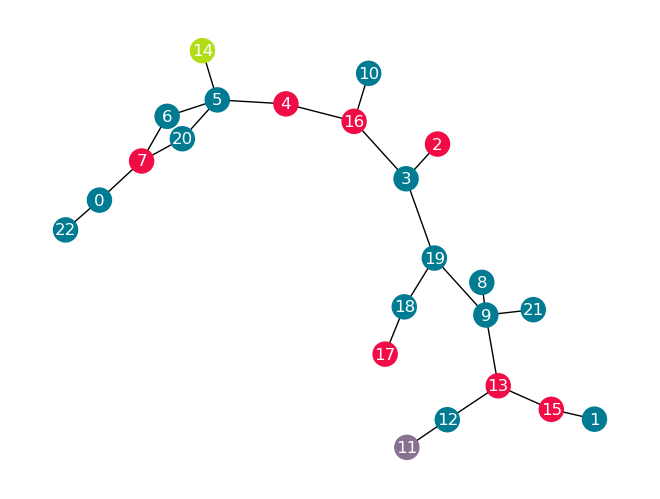

In [149]:
num_nodes = 23
G = nx.connected_watts_strogatz_graph(num_nodes, 3, 0.6, 10)

obstacle_upper_bound = num_nodes//2
num_obstacles = random.randrange(1, obstacle_upper_bound + 1)
obstacles = random.sample(range(num_nodes), num_obstacles)
obstacles_start = copy.deepcopy(obstacles)

# graph_map = {node: node in obstacles if True else False for node in G}
graph_map = {node: node in obstacles for node in G}
# print(graph_map, obstacles)

potential_robot_positions = [node for node in graph_map if not graph_map[node]]
robot_goal_positions = random.sample(potential_robot_positions, k=2)
robot_pos, goal_pos = robot_goal_positions[0], robot_goal_positions[1]

for edge in G.edges:
    G.edges[edge]['pheromones'] = round(random.uniform(1e-3, 1e-2), 4)
    G.edges[edge]['weight'] = 1
# print(potential_robot_positions)

# for edge in G.edges:
#     print(G.edges[edge]['weight'])

# Draw the graph with individual node colors
colors = ['xkcd:pinkish red' if node in obstacles else 'xkcd:ocean' for node in graph_map]
colors[robot_pos] = 'xkcd:greyish purple'
colors[goal_pos] = 'xkcd:yellowish green'
nx.draw(G, with_labels=True, node_color=colors, font_color='white')

# pos = nx.spring_layout(G)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels

In [150]:
def process_obstacle(g, parent, node):
    neighbors = [v for v in g[node] if v != parent]
    length = len(neighbors)
    if node == goal_pos or length > 1:
        return True
    if length == 0:
        return False
        
    return process_obstacle(g, node, neighbors[0])

In [151]:
def move_obstacle(g, node, obstacles, obstacle_poison, num_obstacle_moves):
    possible_moves = sorted([node for node in g[node] if node not in obstacles and node != goal_pos and node != robot_pos])
    
    #recursion
    if len(possible_moves) == 0:
        neighborly_obstacles = [node for node in g[node] if node in obstacles]
        if len(neighborly_obstacles) > 0:
            obstacle_node = random.sample(neighborly_obstacles, 1)[0]
            move_obstacle(g, obstacle_node, obstacles, obstacle_poison, num_obstacle_moves)
    else:      
        move_coefficients = [obstacle_poison[i] for i in possible_moves]

        chosen_move = random.choices(possible_moves, weights=move_coefficients, k = 1)[0]
        obstacles.remove(node)
        obstacles.append(chosen_move)
        num_obstacle_moves += 1

        obstacle_poison[chosen_move] *= 0.643
        print(f'{node} -> {chosen_move}')

In [152]:
def traverse(
    g: nx.Graph,
    start_node: int,
    alpha: float,
    beta: float,
    end_of_the_line,
    saw,
    obstacle_poison,
    num_obstacle_moves,
    obstacles
):
    path = [start_node]
    path_weight = 0
    visited = {start_node}
    u = start_node
    found_goal = False
    global num_moves
    
    while len(visited) != len(g.nodes):

        # GOAL
        if u == goal_pos:
            print("Goal!", path)
            found_goal = True
            break
            
        # TODO Recursively check obstacle nodes
        # Mark every leaf node
        neighbors_drmr = [v for v in g[u]]
        if len(neighbors_drmr) == 1 and u != start_node:
            saw[u] = 0
            print(f'Sawed off: {u}')
            break

        # Mark node if every neighbor except parent is leaf node
        count = 0
        for v in neighbors_drmr:
            if saw[v] == 0:
                count += 1
        if count == len(neighbors_drmr)-1 and u != start_node:
            saw[u] = 0
            break

        # Traverse available neighbors
        neighbors = [v for v in g[u] if v not in visited and v not in obstacles and saw[v] != 0]
        if len(neighbors) == 0: # DEATH
            print("Death", path, path_weight)
            
            obstacle_neighbors = sorted([obs for obs in g[u] if obs in obstacles])
            
            if len(obstacle_neighbors) > 0:
                random_obstacle_neighbor = random.sample(obstacle_neighbors, k = 1)[0];

                if process_obstacle(g, u, random_obstacle_neighbor):
                    move_obstacle(g, random_obstacle_neighbor, obstacles, obstacle_poison, num_obstacle_moves)
                    num_moves += 1

            else:
                if (random.random() < 0.23):
                    random_obstacle = random.sample(obstacles, k = 1)[0]
                    move_obstacle(g, random_obstacle, obstacles, obstacle_poison, num_obstacle_moves)
                    num_moves += 1
            
            if len(path) > 1:
                end_of_the_line[path[-2]] *= 0.9979
            end_of_the_line[u] *= 0.9913
            break
    
        values = ([g[u][v]['pheromones']**alpha / g[u][v]['weight']**beta * end_of_the_line[v] for v in neighbors], [v for v in neighbors])
        
        # Cheating:
        #
        # if goal_pos in neighbors:
        #     chosen_neighbor = goal_pos
        # else:
        #     chosen_neighbor = random.choices(neighbors, weights=values, k=1)[0]
        chosen_neighbor = random.choices(neighbors, weights=values[0], k = 1)[0]
        # 
        # print(values, chosen_neighbor)
        path.append(chosen_neighbor)
        visited.add(chosen_neighbor)
        path_weight += g[u][chosen_neighbor]['weight']
        u = chosen_neighbor

    return path, path_weight, found_goal

In [153]:
from matplotlib import pyplot as plt
from copy import deepcopy

In [154]:
def aco(
    g: nx.Graph,
    num_ants: int,
    rho: float,
    num_iters: int,
    theta: float,
    alpha: float,
    beta:float,
    end_of_the_line,
    obstacles,
    obstacles_start,
):
    saw = [1 for _ in range(num_nodes)]
    obstacle_poison = [1 if node not in obstacles else 0.943 for node in range(num_nodes)]
    num_obstacle_moves = 0
    best_cycle_lens = []
    final_cycle = None
    global num_moves
    
    for i in range(num_iters):
        print(f'Obstacles: {obstacles}\nStarting obstacles: {obstacles_start}')
        cycles = [traverse(g, start_node=robot_pos, alpha=alpha, beta=beta,
                           end_of_the_line = end_of_the_line, saw = saw,
                           obstacle_poison = obstacle_poison,
                           num_obstacle_moves = num_obstacle_moves, obstacles = obstacles)
                           for _ in range(num_ants)]
        
#       smanjivanje feromona - "isparavanje"
        for edge in g.edges:
            # G.edges[edge]['pheromones']
            g.edges[edge]['pheromones'] *= rho

#       dodavanje feromona
        for cycle, cycle_weight, found_cycle in cycles:
            delta = theta / (cycle_weight+1) # TODO za domaci theta se smanjuje kroz iteracije
            for u, v in zip(cycle[:-1], cycle[1:]):
                g[u][v]['pheromones'] += delta

        # goal_cycles = [cycle for cycle in cycles if cycle[2]]
        goal_cycles = [(path, path_weight+num_moves, path_found) for path, path_weight, path_found in cycles if path_found]
        
        if len(goal_cycles) != 0:    
            best_cycle = min(goal_cycles, key=lambda c: c[1])
            best_cycle_lens.append(best_cycle[1])
            if final_cycle is None or best_cycle[1] < final_cycle[1]:
                final_cycle = deepcopy(best_cycle)

        obstacles = copy.deepcopy(obstacles_start)
        num_obstacle_moves = 0
        print(num_moves)
        print(f'\nStart of iteration {i+1}\n')
        num_moves = 0
    
    print(f'Best score: {min(best_cycle_lens)}')
    print(f'Best solution: {final_cycle[0]}')
#     print(final_cycle[1])
    # plt.plot(range(num_iters), best_cycle_lens)

In [155]:
end_of_the_line = [1 for _ in range(num_nodes)]
num_moves = 0
aco(g=G, num_ants=25, rho=0.9, num_iters=75, alpha=0.9, beta=1.5, theta=100.0, end_of_the_line = end_of_the_line, obstacles = obstacles, obstacles_start = obstacles_start)

Obstacles: [7, 2, 17, 4, 13, 16, 15]
Starting obstacles: [7, 2, 17, 4, 13, 16, 15]
Death [11, 12] 1
13 -> 9
Death [11, 12, 13] 2
9 -> 21
Death [11, 12, 13, 9, 19, 3] 5
Sawed off: 8
Death [11, 12, 13, 9, 19, 3] 5
16 -> 10
Death [11, 12, 13, 9, 19, 3, 16] 6
Death [11, 12, 13, 9, 19, 3, 16] 6
4 -> 16
Death [11, 12, 13, 9, 19, 3] 5
Death [11, 12, 13, 9, 19, 3] 5
16 -> 4
Death [11, 12, 13, 9, 19, 3, 16] 6
Death [11, 12, 13, 9, 19, 3, 16] 6
4 -> 5
Death [11, 12, 13, 9, 19, 18] 5
Death [11, 12, 13, 9, 19, 18] 5
Death [11, 12, 13, 9, 19, 3, 16, 4] 7
5 -> 4
Death [11, 12, 13, 9, 19, 3, 16] 6
4 -> 16
Death [11, 12, 13, 9, 19, 3] 5
Death [11, 12, 13, 9, 19, 18] 5
Death [11, 12, 13, 9, 19, 3] 5
Death [11, 12, 13, 9, 19, 3] 5
Death [11, 12, 13, 9, 19, 3] 5
Death [11, 12, 13, 9, 19, 18] 5
Death [11, 12, 13, 9, 19, 3] 5
16 -> 3
Death [11, 12, 13, 9, 19, 18] 5
Death [11, 12, 13, 9, 19, 18] 5
Death [11, 12, 13, 9, 19, 18] 5
9

Start of iteration 1

Obstacles: [7, 2, 17, 4, 13, 16, 15]
Starting obstacle